<a href="https://colab.research.google.com/github/CoderAPS/HuBMAP/blob/main/instance_segmentation_yolov8_v5_20230714.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Medical Instance Segmentation with YOLOv8 version 5
References:<br>
https://docs.ultralytics.com/usage/cfg/#tasks <br>
how YOLO v8 works: https://openmmlab.medium.com/dive-into-yolov8-how-does-this-state-of-the-art-model-work-10f18f74bab1 <br>

Run 1: <br>
Split: 0.75 & 0.25, LR0 = 0.01, LRf = 0.001, batch = 16, droupout = 0.4, patience = 6, epoch = 50 (early stopping at epoch 9),   data = /gdrive/MyDrive/DATA/HuBMAP/images

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!ls /gdrive/MyDrive/DATA/HuBMAP/

annotation_info.csv  masks_white_bkgrnd  sample_submission.csv	train_list.csv
blue_images	     norm_images	 test			val_list.csv
images		     polygons.jsonl	 test2			wsi_meta.csv
images_info.csv      red_images		 test_list.csv
masks		     Results		 tile_meta.csv


In [3]:
!pip install colorama

In [4]:
# libraries needed to create the create the dataset in COCO format
from itertools import chain
import json
import os
import glob
import shutil
from tqdm.notebook import tqdm
from colorama import Fore
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import cv2

# use this code to clear output
from IPython import display
from google.colab import files
#display.clear_output()

In [5]:
# class for creating the dataset
class COCODataset:
    def __init__(self, images_dirpath: str, annotations_filepath: str, length: int = 1633):
        self.train_size = None
        self.val_size = None
        self.length = length
        self.classes = None
        self.labels_counter = None
        self.normalize = None

        self.images_dirpath = images_dirpath
        self.annotations_filepath = annotations_filepath
        self.dataset_dirpath = os.path.join(os.getcwd(), "dataset")
        self.train_dirpath =  os.path.join(self.dataset_dirpath, "train")
        self.val_dirpath =  os.path.join(self.dataset_dirpath, "val")
        self.config_path = os.path.join(self.dataset_dirpath, "coco.yaml")

        self.samples = self.parse_jsonl(annotations_filepath)
        self.classes_dict = {
            "blood_vessel": 0,
            "glomerulus": 1,
            "unsure": 2,
        }

    def __prepare_dirs(self) -> None:
        if not os.path.exists(self.dataset_dirpath):
            os.makedirs(os.path.join(self.train_dirpath, "images"), exist_ok=True)
            os.makedirs(os.path.join(self.train_dirpath, "labels"), exist_ok=True)
            os.makedirs(os.path.join(self.val_dirpath, "images"), exist_ok=True)
            os.makedirs(os.path.join(self.val_dirpath, "labels"), exist_ok=True)
        else:
            raise RuntimeError("Dataset already exists!")

    def __define_splitratio(self) -> None:
        self.train_size = round(self.length * self.train_size)
        self.val_size = self.length - self.train_size
        assert self.train_size + self.val_size == self.length

    def parse_jsonl(self, path: str) -> list[dict, ...]:
        with open(path, 'r') as json_file:
            jsonl_samples = [
                json.loads(line)
                for line in tqdm(
                    json_file, desc="Processing polygons", total=self.length
                )
            ]
        return jsonl_samples

    def __define_paths(self, i: int) -> dict:
        data_path = self.val_dirpath
        if i < self.train_size:
            data_path = self.train_dirpath
        return {
            "images": os.path.join(data_path, "images"),
            "labels": os.path.join(data_path, "labels")
        }

    @staticmethod
    def __get_label_path(paths_dict: dict, identifier: str) -> str:
        return os.path.join(
            paths_dict["labels"],
            f"{identifier}.txt"
        )

    @staticmethod
    def __get_image_path(paths_dict: dict, identifier: str) -> str:
        return os.path.join(
            paths_dict["images"],
            f"{identifier}.tif"
        )

    def __copy_image(self, dst_path: str, identifier: str) -> str:
        shutil.copyfile(
            os.path.join(self.images_dirpath, f"{identifier}.tif"),
            dst_path
        )

    def __copy_label(self, annotations: list, dst_path: str) -> None:
        with open(dst_path, "w") as file:
            for annotation in annotations:
                coordinates = annotation["coordinates"][0]
                label = self.classes_dict[annotation["type"]]
                if label in self.classes:
                    if coordinates:
                        if self.normalize:
                            coordinates = np.array(coordinates) / 512.0
                        coordinates = " ".join(map(str, chain(*coordinates)))
                        file.write(f"{label} {coordinates}\n")
                        self.labels_counter += 1

    def __splitfolders(self):
        for i, line in tqdm(
                enumerate(self.samples),
                desc="Dataset creation", total=self.length
        ):
            self.labels_counter = 0
            identifier = line["id"]
            annotations = line["annotations"]
            paths_dict = self.__define_paths(i)

            dst_image_path = self.__get_image_path(paths_dict, identifier)
            dst_label_path = self.__get_label_path(paths_dict, identifier)

            self.__copy_image(dst_image_path, identifier)
            self.__copy_label(annotations, dst_label_path)

            if self.labels_counter == 0:
                os.remove(dst_image_path)
                os.remove(dst_label_path)

    def __count_dataset(self) -> dict:
        train_images = len(os.listdir(os.path.join(self.train_dirpath, "images")))
        train_labels = len(os.listdir(os.path.join(self.train_dirpath, "labels")))
        val_images = len(os.listdir(os.path.join(self.val_dirpath, "images")))
        val_labels = len(os.listdir(os.path.join(self.val_dirpath, "labels")))
        return {
            "train_images": train_images,
            "train_labels": train_labels,
            "val_images": val_images,
            "val_labels": val_labels
        }

    @staticmethod
    def __check_sanity(count_dict: dict) -> None:
        assert count_dict["train_images"] == count_dict["train_labels"]
        assert count_dict["val_images"] == count_dict["val_labels"]

    def __finalizing(self, count_dict: dict) -> None:
        assert os.path.exists(self.dataset_dirpath)

        example_structure = [
            "dataset",
            "train", "labels", "images",
            "val", "labels", "images"
        ]

        dir_bone = (
            dirname.split("/")[-1]
            for dirname, _, filenames in os.walk(self.dataset_dirpath)
            if dirname.split("/")[-1] in example_structure
        )

        try:
            print("\n~ HuBMAP Dataset Structure ~\n")
            print(
            f"""
          ├── {next(dir_bone)}
          │   │
          │   ├── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
          │   │
          │   ├── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
            """
            )
        except StopIteration as e:
            print(e)
        else:
            print(Fore.GREEN + "-> Success")
            print(Fore.GREEN + f"Train dataset: {count_dict['train_images']}\nVal dataset: {count_dict['val_images']}")

    def get_config(self) ->dict:
        names = ["blood_vessel", "glomerulus", "unsure"]
        return {
            "train": str(self.train_dirpath),
            "val": str(self.val_dirpath),
            "names": [names[i] for i in self.classes]
        }

    @staticmethod
    def display_config(config: dict) -> None:
        print(Fore.BLACK + "\n~ HuBMAP Config Structure ~\n")
        print(
        f"""
      │   │
      │   ├── train
      │   │   └── {config['train']}/images
      │   │
      │   │
      │   ├── val
      │   │   └── {config['val']}/images
      │   │
      │   │
      │   ├── names
      │   │   └── {' '.join(config['names'])}
        """
        )
        print(Fore.GREEN + "-> Success")
        print(Fore.GREEN + f"Number of classes: {len(config['names'])}"
                           f"\nClasses: {' '.join(config['names'])}"
              )

    def write_config(self, config: dict) -> None:
        with open(self.config_path, mode="w") as f:
            yaml.safe_dump(stream=f, data=config)

    def __call__(self, train_size: float,
                 classes: list[int, ...],
                 make_config: bool = True,
                 normalize: bool = True
                ) -> None:

        self.train_size = train_size
        self.classes = classes
        self.normalize = normalize

        self.__define_splitratio()
        self.__prepare_dirs()
        self.__splitfolders()
        count_dict = self.__count_dataset()
        self.__check_sanity(count_dict)
        self.__finalizing(count_dict)

        if make_config:
            config = self.get_config()
            self.write_config(config)
            self.display_config(config)

In [6]:
# instantiate a COCODataset object
path = '/gdrive/MyDrive/DATA/HuBMAP/'
coco = COCODataset(
    annotations_filepath= path + 'polygons.jsonl',
    images_dirpath=path + 'images/'
)

Processing polygons:   0%|          | 0/1633 [00:00<?, ?it/s]

In [7]:
coco(train_size=0.75, classes=[0, 1, 2])

Dataset creation:   0%|          | 0/1633 [00:00<?, ?it/s]


~ HuBMAP Dataset Structure ~


          ├── dataset
          │   │
          │   ├── val
          │   │   └── labels
          │   │   └── images
          │   │
          │   ├── train
          │   │   └── labels
          │   │   └── images
            
-> Success
Train dataset: 1225
Val dataset: 408

~ HuBMAP Config Structure ~


      │   │
      │   ├── train
      │   │   └── /content/dataset/train/images
      │   │
      │   │
      │   ├── val
      │   │   └── /content/dataset/val/images
      │   │
      │   │
      │   ├── names
      │   │   └── blood_vessel glomerulus unsure
        
-> Success
Number of classes: 3
Classes: blood_vessel glomerulus unsure


In [8]:
!ls dataset

coco.yaml  train  val


In [9]:
!pip install ultralytics
display.clear_output()

In [10]:
pip show ultralytics

Name: ultralytics
Version: 8.0.135
Summary: Ultralytics YOLOv8 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: https://github.com/ultralytics/ultralytics
Author: Ultralytics
Author-email: hello@ultralytics.com
License: AGPL-3.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, opencv-python, pandas, Pillow, psutil, PyYAML, requests, scipy, seaborn, torch, torchvision, tqdm
Required-by: 


In [10]:
!pip install pycocotools
display.clear_output()


In [11]:
pip show pycocotools


Name: pycocotools
Version: 2.0.6
Summary: Official APIs for the MS-COCO dataset
Home-page: https://github.com/ppwwyyxx/cocoapi
Author: 
Author-email: 
License: FreeBSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, numpy
Required-by: 


In [12]:
from pycocotools import _mask as coco_mask
import ultralytics
from ultralytics import YOLO



In [13]:
ultralytics.checks()


Ultralytics YOLOv8.0.135 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (4 CPUs, 25.5 GB RAM, 26.2/166.8 GB disk)


In [14]:
!nvidia-smi

Sat Jul 15 02:18:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
def main():
    model = YOLO("yolov8x-seg.pt")
    model.train(
        # Project
        project="HuBMAP",
        name="yolov8x-seg",

        # Random Seed parameters
        deterministic=True,
        seed=43,

        # Data & model parameters
        data="/content/dataset/coco.yaml",
        save=True,
        save_period=5,
        pretrained=True,
        imgsz=512,

        # Training parameters
        epochs=50,
        batch=16,
        workers=8,
        val=True,
        device= 0,

        # Optimization parameters
        lr0=0.01,
        lrf=0.001,
        patience=6,
        optimizer="SGD",
        momentum=0.947,
        weight_decay=0.0005,
        close_mosaic=3,
        dropout = 0.4
    )

In [16]:
if __name__ == '__main__':
    main()

100%|██████████| 137M/137M [00:07<00:00, 18.5MB/s]
Ultralytics YOLOv8.0.135 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=segment, mode=train, model=yolov8x-seg.pt, data=/content/dataset/coco.yaml, epochs=50, patience=6, batch=16, imgsz=512, save=True, save_period=5, cache=False, device=0, workers=8, project=HuBMAP, name=yolov8x-seg, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=3, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.4, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=t

In [17]:
files.download('/content/HuBMAP/yolov8x-seg/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
import matplotlib.pyplot as plt
from PIL import Image

In [19]:
dirlist = os.listdir("/content/dataset/val/images")
print(dirlist[:5])

['f45a29109ff5.tif', 'e868c30b2af7.tif', 'd0c516c02696.tif', 'eaa85fa2b857.tif', 'db20b95a3ab9.tif']



image 1/1 /content/dataset/val/images/fbd64e93f84d.tif: 512x512 17 blood_vessels, 65.8ms
Speed: 1.4ms preprocess, 65.8ms inference, 4.4ms postprocess per image at shape (1, 3, 512, 512)


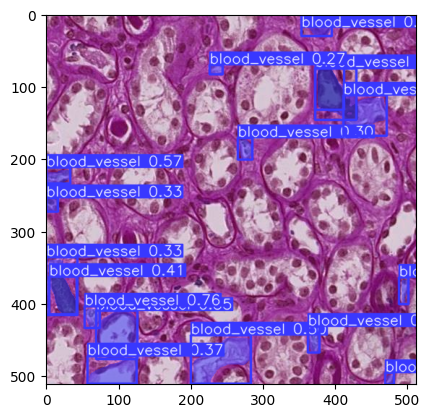

In [20]:
model = YOLO("/content/HuBMAP/yolov8x-seg/weights/best.pt")
history = model.predict("/content/dataset/val/images/fbd64e93f84d.tif")[0]
image = history.plot()
plt.imshow(image)
plt.show()

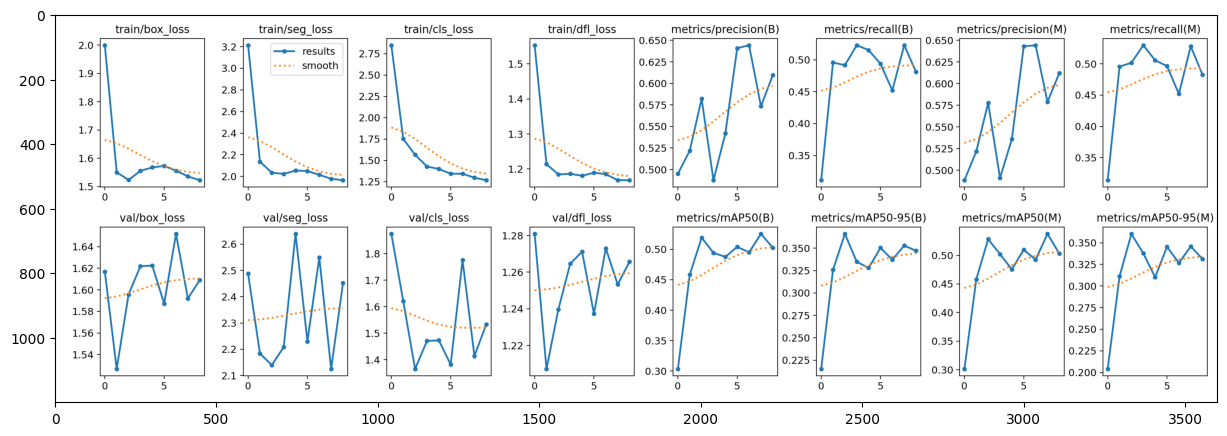

In [21]:
F1_curve = Image.open("/content/HuBMAP/yolov8x-seg/results.png")
plt.figure(figsize=(15,20))
plt.imshow(F1_curve)
plt.show()

In [22]:
results = pd.read_csv("/content/HuBMAP/yolov8x-seg/results.csv")
results.head()
results.to_csv('/gdrive/MyDrive/DATA/HuBMAP/Results/is_yolov8_v5_20230714.csv')

In [23]:
results

,epoch,train/box_loss,train/seg_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),metrics/precision(M),metrics/recall(M),metrics/mAP50(M),metrics/mAP50-95(M),val/box_loss,val/seg_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,0,1.9995,3.2134,2.8495,1.5534,0.49513,0.31126,0.30362,0.21525,0.48846,0.31383,0.30144,0.20406,1.6169,2.4874,1.8744,1.2809,0.070390,0.003290,0.003290
1,1,1.5502,2.1360,1.7523,1.2139,0.52192,0.49569,0.45836,0.32593,0.52175,0.49551,0.45812,0.31119,1.5267,2.1838,1.6209,1.2072,0.040257,0.006491,0.006491
2,2,1.5232,2.0343,1.5652,1.1844,0.58208,0.49147,0.51910,0.36601,0.57762,0.50170,0.52841,0.36030,1.5957,2.1397,1.3652,1.2397,0.009992,0.009559,0.009559
3,3,1.5553,2.0230,1.4277,1.1864,0.48756,0.52277,0.49420,0.33485,0.49112,0.52977,0.50207,0.33773,1.6220,2.2084,1.4707,1.2646,0.009401,0.009401,0.009401
4,4,1.5675,2.0543,1.3993,1.1806,0.54190,0.51518,0.48753,0.32797,0.53600,0.50569,0.47557,0.31015,1.6225,2.6393,1.4731,1.2712,0.009401,0.009401,0.009401
5,5,1.5728,2.0490,1.3440,1.1895,0.64087,0.49362,0.50402,0.35034,0.64294,0.49643,0.50992,0.34529,1.5873,2.2300,1.3814,1.2373,0.009201,0.009201,0.009201
6,6,1.5557,2.0150,1.3435,1.1852,0.64434,0.45196,0.49503,0.33728,0.64426,0.45187,0.49244,0.32671,1.6519,2.5492,1.7756,1.2730,0.009001,0.009001,0.009001
7,7,1.5361,1.9779,1.2967,1.1682,0.57342,0.52276,0.52530,0.35288,0.57880,0.52800,0.53762,0.34573,1.5920,2.1253,1.4139,1.2533,0.008801,0.008801,0.008801
8,8,1.5221,1.9643,1.2670,1.1679,0.60959,0.48081,0.50265,0.34716,0.61213,0.48223,0.50306,0.33117,1.6090,2.4518,1.5331,1.2657,0.008601,0.008601,0.008601


In [ ]:
plt.figure

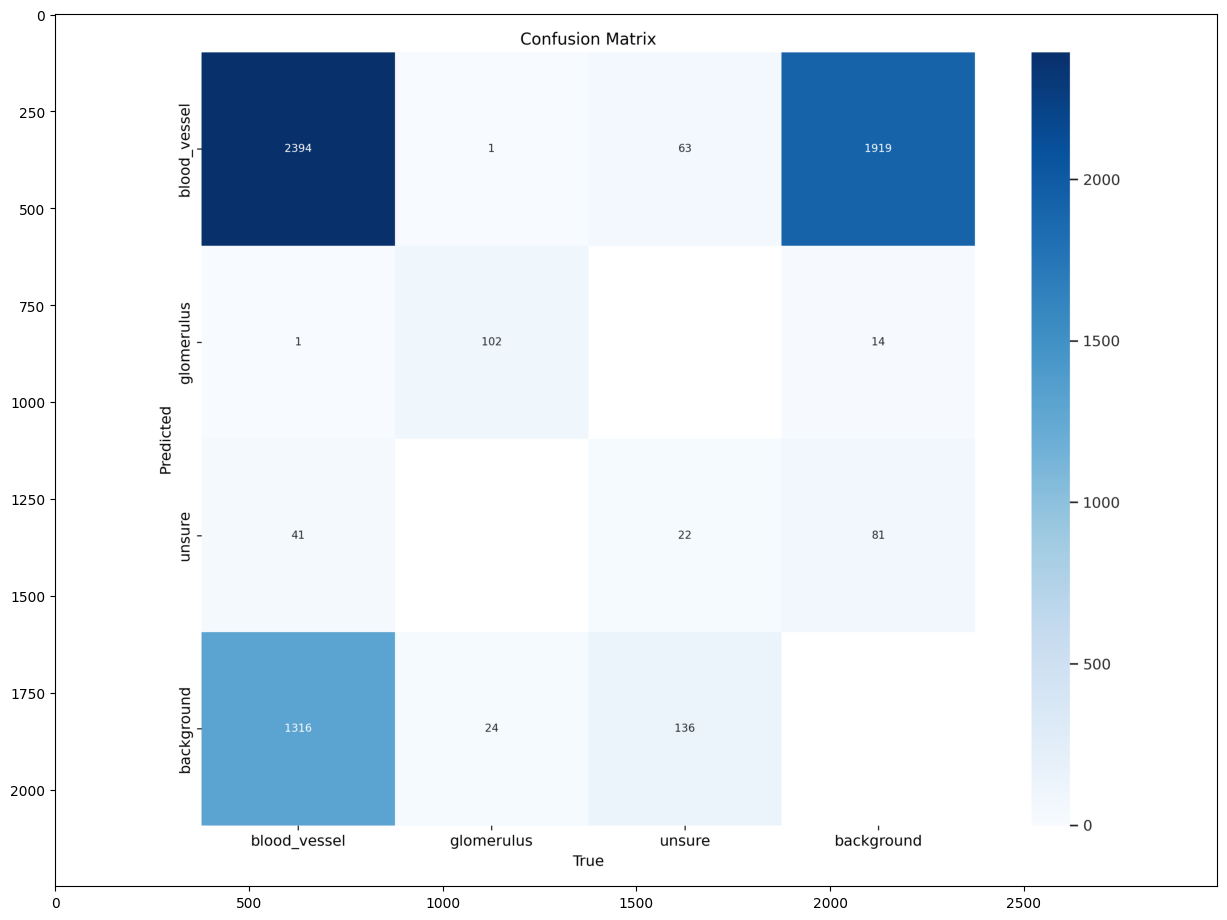

In [24]:
plt.figure(figsize=(15,20))
confusion_matrix = Image.open("/content/HuBMAP/yolov8x-seg/confusion_matrix.png")
plt.imshow(confusion_matrix)
plt.show()


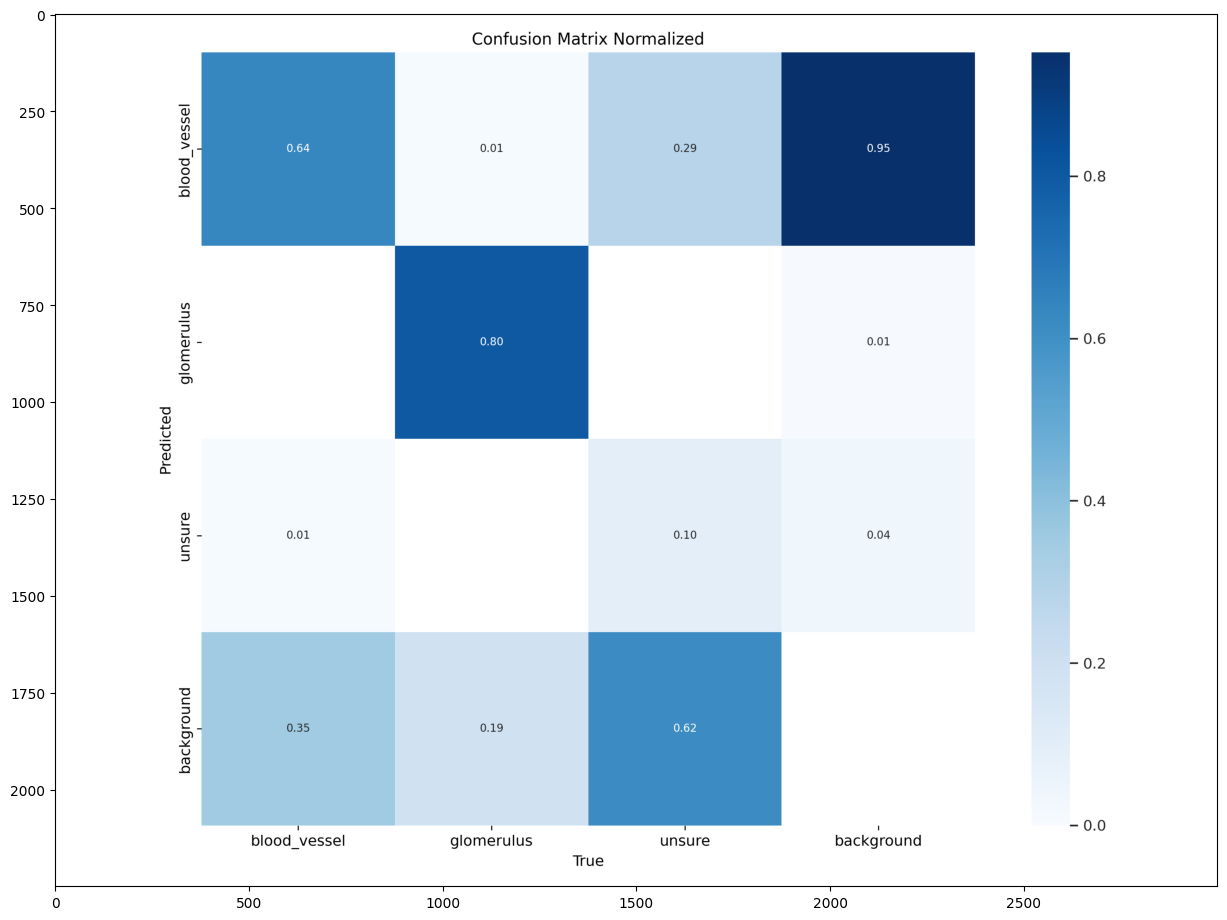

In [25]:
plt.figure(figsize=(15,20))
confusion_matrix = Image.open("/content/HuBMAP/yolov8x-seg/confusion_matrix_normalized.png")
plt.imshow(confusion_matrix)
plt.show()